In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torchmetrics
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from cnn import ResNet18, ResNet, BasicBlock
import tqdm

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


(-0.5, 31.5, 31.5, -0.5)

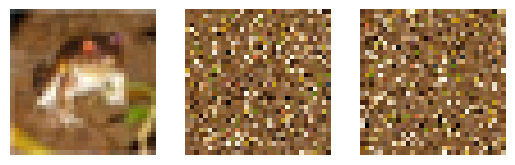

In [3]:
plt.subplot(1,3,1)
plt.imshow(train_dataset[0][0].permute([1,2,0]))
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(train_dataset[0][0].view(3,-1)[:, torch.randperm(32*32)].reshape(3, 32, 32).permute([1,2,0]))
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(train_dataset[0][0].view(3,-1)[:, torch.randperm(32*32)].reshape(3, 32, 32).permute([1,2,0]))
plt.axis("off")

In [91]:
class CIFAR10Dataset(Dataset):
    def __init__(self, dataset, permutation, task_id):
        self.dataset = dataset
        self.permutation = permutation
        self.task_id = task_id
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        
        image, label = self.dataset[idx]
        image = image.view(3,-1)[:, self.permutation].reshape(3, 32, 32)
        
        return image, label
        

In [92]:
task_1_perm = list(range(32*32))
task_2_perm = torch.randperm(32*32)

task_1_train_dataset = CIFAR10Dataset(train_dataset, task_1_perm, "1")
task_2_train_dataset = CIFAR10Dataset(train_dataset, task_2_perm, "2")
task_1_test_dataset = CIFAR10Dataset(test_dataset, task_1_perm, "1")
task_2_test_dataset = CIFAR10Dataset(test_dataset, task_2_perm, "2")

In [93]:
task_1_train_dataloader = DataLoader(task_1_train_dataset, batch_size = 16, shuffle=True, pin_memory=True)
task_2_train_dataloader = DataLoader(task_2_train_dataset, batch_size = 16, shuffle=True, pin_memory=True)
task_1_test_dataloader = DataLoader(task_1_test_dataset, batch_size = 16, shuffle=False, pin_memory=True)
task_2_test_dataloader = DataLoader(task_2_test_dataset, batch_size = 16, shuffle=False, pin_memory=True)

In [94]:
model = ResNet18()

In [95]:
trainer = pl.Trainer(max_epochs = 3, accelerator = "gpu", enable_progress_bar = True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [96]:
trainer.fit(model, task_1_train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | conv1     | Conv2d             | 1.7 K 
1 | bn1       | BatchNorm2d        | 128   
2 | layer1    | Sequential         | 147 K 
3 | layer2    | Sequential         | 525 K 
4 | layer3    | Sequential         | 2.1 M 
5 | layer4    | Sequential         | 8.4 M 
6 | linear    | Linear             | 5.1 K 
7 | criterion | CrossEntropyLoss   | 0     
8 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [97]:
torch.save(model.state_dict(), open("classifier.pth", "wb"))

In [102]:
class ResNetContinual(pl.LightningModule):
    
    def __init__(self, old_resnet): 
        
        super().__init__()
        self.old_resnet = old_resnet
        self.new_resnet = ResNet18()
        self.new_resnet.load_state_dict(old_resnet.state_dict())
        self.accuracy = torchmetrics.Accuracy(task = "multiclass", num_classes = 10)
        self.acc = 0
        self.loss = 0
        self.count = 0
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        
        return self.new_resnet(x)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.new_resnet.parameters(), lr=0.00005)
        
        return [optimizer]
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        
        for parameter1, parameter2 in zip(self.old_resnet.parameters(), self.new_resnet.parameters()):
            loss += 0.001*F.mse_loss(parameter1, parameter2)
        
        
        self.acc = (self.acc*self.count + self.accuracy(y_hat, y))/(self.count + 1)
        self.loss = (self.loss*self.count + loss.item())/(self.count + 1)
        self.count+=1
        self.log("accuracy", self.acc,  prog_bar=True)
        self.log("loss", self.loss,  prog_bar=True)
        
        return loss
    
    def on_train_epoch_end(self):
        self.acc = 0
        self.loss = 0
        self.count = 0
        # self.old_resnet.load_state_dict(new_resnet.state_dict())
        
        

In [103]:
model.load_state_dict(torch.load(open("classifier.pth", "rb")))

<All keys matched successfully>

In [104]:
model_task1 = ResNetContinual(old_resnet = model)

In [105]:
trainer = pl.Trainer(max_epochs = 5, accelerator = "gpu", enable_progress_bar = True, accumulate_grad_batches=8)
trainer.fit(model_task1, task_2_train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | old_resnet | ResNet             | 11.2 M
1 | new_resnet | ResNet             | 11.2 M
2 | accuracy   | MulticlassAccuracy | 0     
3 | criterion  | CrossEntropyLoss   | 0     
--------------------------------------------------
22.3 M    Trainable params
0         Non-trainable params
22.3 M    Total params
89.392    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [106]:
preds = []
true = []
model_task1.cuda()
for batch in tqdm.tqdm(task_1_test_dataloader):
    x, y = batch
    x = x.cuda()
    with torch.no_grad():
        pred = model_task1(x)
    
    preds.append(pred.cpu())
    true.append(y)
    
    del x
    del pred


100%|██████████| 625/625 [00:20<00:00, 31.10it/s]


In [107]:
accuracy = torchmetrics.Accuracy(task = "multiclass", num_classes = 10)

In [108]:
print("Task 1 accuracy:", accuracy(torch.cat(preds), torch.cat(true)))

Task 1 accuracy: tensor(0.5377)


In [109]:
preds = []
true = []
model_task1.cuda()
for batch in tqdm.tqdm(task_2_test_dataloader):
    x, y = batch
    x = x.cuda()
    with torch.no_grad():
        pred = model_task1(x)
    
    preds.append(pred.cpu())
    true.append(y)
    
    del x
    del pred


100%|██████████| 625/625 [00:18<00:00, 33.45it/s]


In [110]:
print("Task 2 accuracy:", accuracy(torch.cat(preds), torch.cat(true)))

Task 2 accuracy: tensor(0.4822)
